# QAOA using JAX and covariance matrices

In this notebook, we examine how using JAX's `jit` and `grad` functions can improve QAOA minimisation. We work with free fermionic states and quadratic Hamiltonians throughout, and perform the quantum evolution efficiently by employing covariance matrices.

The state targeted by QAOA is the ground state of the following Ising model

$$
\sum_i R_i X_i X_{i+1} + S_i Z_i
$$

where $R_i, S_i$ are uniform random variables in the interval $[-1, 1]$. We work with open boundary conditions.

### Imports and set up:

In [190]:
# Change to directory having the code files so as to be able to import them

In [191]:
cd ../Code

/home/gmatos/phd/projects/GaussianCircuits/Code


In [192]:
# Import data handling facilities
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
# Must make sure current directory is /Code
from differentiable_covariance import ising_largest_eigenvalue

In [193]:
# Set default plotting parameters
mpl.rc("text", usetex=True)
mpl.rc("font", size=10)
mpl.rc("axes", labelsize=10, titlesize=11)
mpl.rc("xtick", labelsize=10)
mpl.rc("ytick", labelsize=10)
mpl.rc("legend", frameon=False, fancybox=False)

Load QAOA optimisation data:

In [194]:
df_nojax = pd.read_csv("../Data/ProducingScript=07_optimization_gradient_free.py.csv")
df_jax = pd.read_csv("../Data/ProducingScript=08_optimization_with_jax.py.csv")
df_jax_global = pd.read_csv("../Data/ProducingScript=08_optimization_with_jax.py_global.csv")

# Add additional data to DataFrames
# (not currently needed)
import re
from differentiable_covariance import ising_largest_eigenvalue, ising_ground_state_energy
for df in [df_nojax, df_jax, df_jax_global]:
    jz = np.array(eval(re.sub(r"\s+", ",", df.jz.iloc[0])))
    jx = np.array(eval(re.sub(r"\s+", ",", df.jx.iloc[0])))
    df.largest_eigenvalue = ising_largest_eigenvalue(jz, jx)
    df.ground_state_energy = ising_ground_state_energy(jz, jx)
    df["eminimum"] = df.minimum * len(jz)

## Results:

### L = 8

We can see that using JAX makes the optimisation several orders of magnitude faster

Text(0.5, 1.0, '$L=8$')

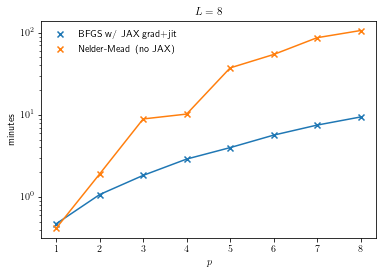

In [195]:
fig, ax = plt.subplots()
ax.plot(df_jax.p, df_jax.time/60)
ax.scatter(df_jax.p, df_jax.time/60, marker = "x", label = "BFGS w/ JAX grad+jit")
ax.plot(df_nojax.p, df_nojax.time/60)
ax.scatter(df_nojax.p, df_nojax.time/60, marker = "x", label = "Nelder-Mead (no JAX)")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$p$")
ax.set_ylabel("minutes")
ax.set_title("$L=8$")

Here we plot the ratio between the time taken by then optimisation when using JAX and when not using it. We can see that at higher $p$ we get an optimisation that is $12$ times (!) faster 

Text(0.5, 1.0, '$L=8$')

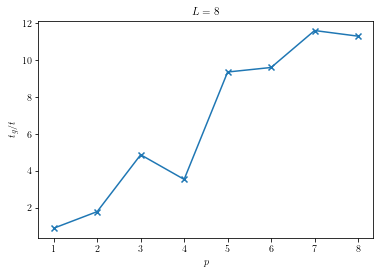

In [196]:
fig, ax = plt.subplots()
ax.plot(df_jax.p, df_nojax.time / df_jax.time)
ax.scatter(df_jax.p, df_nojax.time / df_jax.time, marker = "x")
ax.set_xlabel("$p$")
ax.set_ylabel(r"$t_g/t$")
ax.set_title("$L=8$")

Here we compare the minima found by using three different strategies:
* A BFGS minimization algorithm where the cost function and gradient have been `jit`'d by JAX and the gradient is obtained and supplied by using the `grad` JAX function
* The same as above, but coupled to a basinhopping global minimization algorithm with $20$ jumps (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html)
* A simple Nelder-Mead minimization algorithm

We see from the results that not only using JAX+BFGS is substantially faster, but it also leads to better results. Note however that using `basinhopping` global optimization seems to be necessary, as it improves upon a simple local minimisation.

Text(0.5, 1.0, '$L=8$')

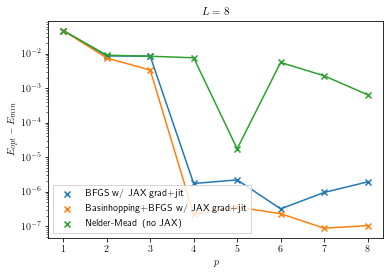

In [200]:
fig, ax = plt.subplots()
for df, l in zip([df_jax, df_jax_global, df_nojax], ["BFGS w/ JAX grad+jit", "Basinhopping+BFGS w/ JAX grad+jit", "Nelder-Mead (no JAX)"]):
    v = df.minimum - df.exact_energy
    ax.plot(df.p, v)
    ax.scatter(df.p, v, marker = "x", label = l)
ax.legend(loc = "lower left", frameon = True)
ax.set_xlabel("$p$")
ax.set_ylabel(r"$E_{opt} - E_{min}$")
ax.set_yscale("log")
ax.set_title("$L=8$")

### L = 6

At L=6, we see that the energy is still going down even at $p=6$. This is in contrast to previous results we had, where we could exactly prepare the state at $p=3$ for this system size (the number of optimisation parameters was low enough so as to not cause any issues, which only really appeared at $L=8$).

This may be due to the difference in the cost function used; here we are using the energy, while previously we had used the overlap.

In [198]:
df_l6 = pd.read_csv("../Data/ProducingScript=08_optimization_with_jax.py_L=6.csv")

Text(0.5, 1.0, '$L=6$')

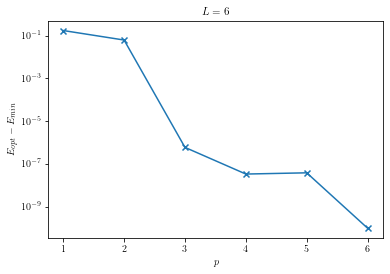

In [199]:
fig, ax = plt.subplots()
v = df_l6.minimum - df_l6.exact_energy
ax.plot(df_l6.p, v)
ax.scatter(df_l6.p, v, marker = "x")
ax.set_xlabel("$p$")
ax.set_ylabel(r"$E_{opt} - E_{min}$")
ax.set_yscale("log")
ax.set_title("$L=6$")